In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import spacy
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_csv('/content/training_data.csv')

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())

Memory usage         1.83 MB
Dataset shape    (120000, 2)


In [5]:
# Example description
data.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [6]:
# Example description
data['text'].iloc[0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [7]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values    0
Number of duplicate observations              0


# Project objective
- Given text consist of news article headlines. Classify headlines on 4 different category.
These headlines are labelled as either 0, 1, 2 and 3, these values correspond to 4 types of news topics which are 'World', 'Sports', 'Business' and 'Sci/Tech'.

In [8]:
data_w = data[data['label'] == 0] # World
data_s = data[data['label'] == 1] # Sports
data_b = data[data['label'] == 2] # Business
data_t = data[data['label'] == 3] # Sci/Tech

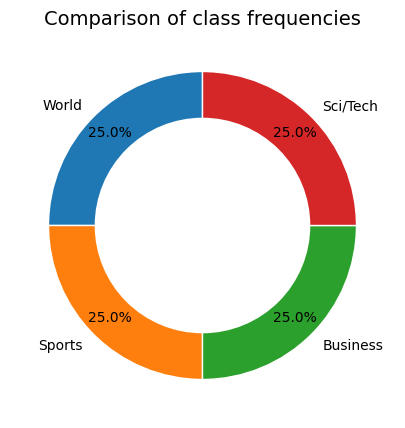

In [9]:
# Visualization of class frequencies
values = [len(data_w), len(data_s), len(data_b), len(data_t)]
labels = ['World', 'Sports', 'Business', 'Sci/Tech']

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(values, labels=labels, autopct='%1.1f%%', wedgeprops={'edgecolor': 'white'}, startangle=90, pctdistance=0.85)

# Add a circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add title
plt.title("Comparison of class frequencies", fontsize=14)

# Show the plot
plt.show()


## observation;
- data is set to be balanced dataset with each label of 25 percent.

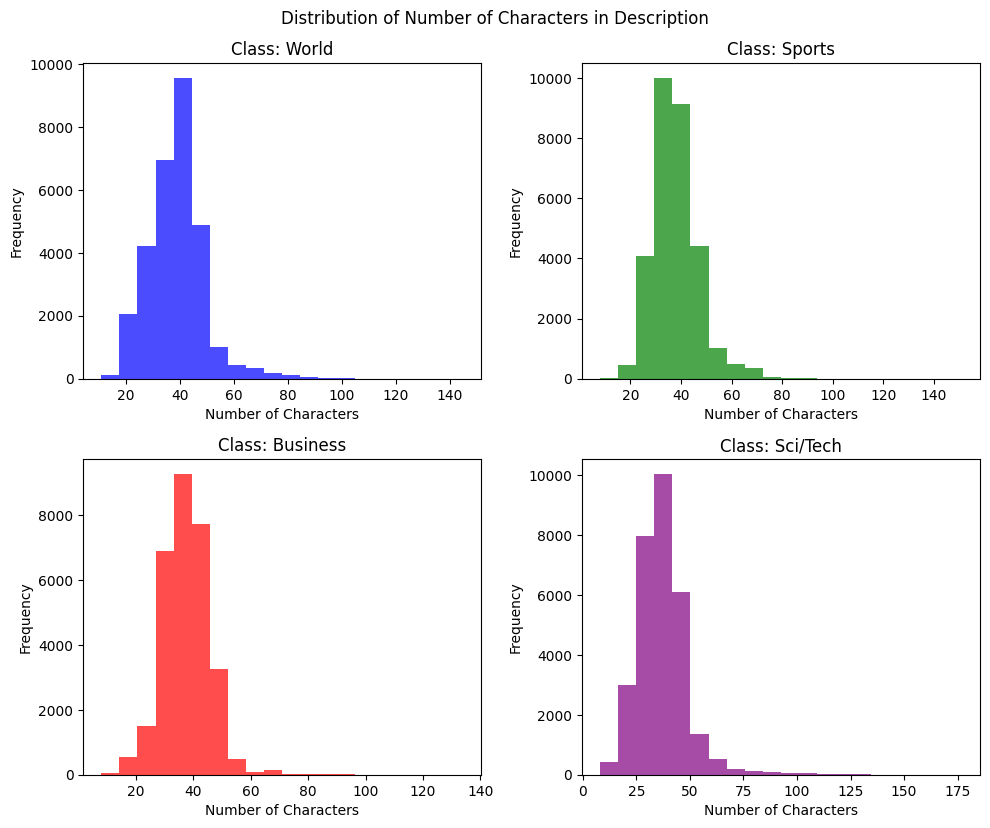

In [10]:
import matplotlib.pyplot as plt

# Distribution of number of characters in description
data_w_char = data_w['text'].str.split().map(len)
data_s_char = data_s['text'].str.split().map(len)
data_b_char = data_b['text'].str.split().map(len)
data_t_char = data_t['text'].str.split().map(len)

fig, ax = plt.subplots(2, 2, figsize=(10, 8.4), sharey=False)

ax[0, 0].hist(data_w_char, bins=20, color='blue', alpha=0.7)
ax[0, 0].set_title('Class: World')

ax[0, 1].hist(data_s_char, bins=20, color='green', alpha=0.7)
ax[0, 1].set_title('Class: Sports')

ax[1, 0].hist(data_b_char, bins=20, color='red', alpha=0.7)
ax[1, 0].set_title('Class: Business')

ax[1, 1].hist(data_t_char, bins=20, color='purple', alpha=0.7)
ax[1, 1].set_title('Class: Sci/Tech')

fig.suptitle("Distribution of Number of Characters in Description")

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Number of Characters")
        ax[i, j].set_ylabel("Frequency")

plt.tight_layout()
plt.show()



- All four classes show right-skewed distributions (lower character count, with fewer longer descriptions)
- 60-70 is the best split point for the longer text.

## preprocess

In [11]:
def convert_to_lowercase(text):
    return text.lower()



In [12]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

In [13]:
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

In [14]:
import re
from html import unescape

""""Staples Profit Up Sharply, to Enter China  NEW YORK (Reuters) - Staples Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=SPLS.O target=/stocks/quickinfo/fullquote""&gt;SPLS.O&lt;/A&gt;, the top U.S.  office products retailer, on Tuesday reported a 39 percent jump  in quarterly profit, raised its full-year forecast and said it  plans to enter the fast-growing Chinese market.",2
"""
def clean_html_tags(text):
    text = unescape(text)
    text = re.sub(r'<A HREF=".*?">.*?</A>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r',\d+$', '', text)

    return text.strip()

In [15]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
##Substitution of Acronyms
## this is sensetive so , need to add manually based on the text

In [4]:

acronyms_dict = pd.read_json(acronyms_dict, typ = 'series')
acronyms_list = list(acronyms_dict.keys())

def convert_acronyms(text):
    words = []
    for word in text.split():
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

In [17]:
###Substitution of Contractions
##Examples: I'm = I am, let's = let us, won't = would not, howdy = how do you do.
contractions_dict = pd.read_json(contractions_dict, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in text.split():
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted



In [18]:
##Removal of Stop Words
stops = stopwords.words("english") # stopwords

In [19]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stops])

In [ ]:
##Spelling Correction
spell = SpellChecker()

def pyspellchecker(text):
    word_list = text.split()
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

In [ ]:
##Stemming and Lemmatization
## we can do stemming but it disregards the words formation

In [20]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    return text_spacy

In [21]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in text.split() if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

In [22]:
import string

def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_punctuation(text)
    text = clean_html_tags(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    # text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    return text

In [23]:
text_normalizer("ash")

'ash'

In [24]:
### Train the model
from sklearn.model_selection import train_test_split

In [30]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [31]:
train_df.head()

,text,label
80385,New Media Center OS Plays Well Microsoft #39;s...,3
50696,First Look: Voq Cell Phone Needs Work Sierra W...,3
118723,Controversy continues to follow Bryant Seldom ...,1
17083,Oracle Products Exposed To Hackers Oracle has ...,3
57474,FTC Filing Targets Malicious Spyware FTC Filin...,3


In [27]:
# train_df = train_df[:100]
# test_df = test_df[:100]

In [32]:
from tqdm.auto import tqdm
tqdm.pandas()

In [33]:
train_df["text"] = train_df["text"].progress_apply(text_normalizer)
test_df["text"] = test_df["text"].progress_apply(text_normalizer)


  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

In [34]:
train_df.to_csv("preprocess_train.csv")
test_df.to_csv("preprocess_test.csv")

In [35]:
train_df

,text,label
80385,new medium center os play well microsoft new w...,3
50696,first look voq cell phone need work sierra wir...,3
118723,controversy continue follow bryant seldom some...,1
17083,oracle product expose hacker oracle issue aler...,3
57474,ftc filing target malicious spyware ftc filing...,3
...,...,...
1458,deere earning jump raise forecast chicago reut...,2
69119,quotblog quot word year word quotblog quot wor...,3
52889,italy seek libya migrant deal italy leader ber...,0
53452,web take san francisco next time visit one fav...,3


In [36]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.6 MB/s eta 0:00:00


## Training

In [37]:
from datasets import Dataset
from transformers import AutoTokenizer
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Convert datasets to tokenized format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True).to(device)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/96000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

In [5]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)
model.to(device)
# Prepare data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none",
)

# Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model('model')

In [39]:
trainer.save_model('model')

In [40]:
!zip -r model.zip model/*

  adding: model/config.json (deflated 50%)
  adding: model/model.safetensors (deflated 8%)
  adding: model/special_tokens_map.json (deflated 42%)
  adding: model/tokenizer_config.json (deflated 75%)
  adding: model/tokenizer.json (deflated 71%)
  adding: model/training_args.bin (deflated 52%)
  adding: model/vocab.txt (deflated 53%)


In [41]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00


In [42]:
import evaluate
from transformers import pipeline

In [43]:
df = pd.read_csv("/content/test_data.csv", names=["text", "label"])

In [52]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)  # Use GPU if available

# Load accuracy metric
metric = evaluate.load("accuracy")

# Run inference with tqdm progress bar
predictions = []
for text in tqdm(df["text"].tolist(), desc="Evaluating"):
    pred = classifier(text_normalizer(text))[0]["label"]  # Get predicted label
    pred = int(pred.replace("LABEL_", ""))  # Extracts the number
    predictions.append(pred)  # Convert to integer

# Compute accuracy
accuracy = metric.compute(predictions=predictions, references=df["label"].tolist())

print(f"Model Accuracy: {accuracy['accuracy']:.4f}")

Device set to use cuda:0


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Model Accuracy: 0.8500


## Conclusion

we get the good accuracy , but the problem seems to be multi-class classification not classification. 
since for the data 
- Rory McIlroy: World number two backs plans to 'roll back' golf ball technology
- this can be both sports and scipy. (these are the some case where model fails)

- Bigger Decoder based Model could be better.